# Сборный проект #

## Описание проекта ##

Интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности, которые позволят сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков»

### Описание данных  ###

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

*Данные за 2016 год могут быть неполными.*


## Обзор данных ## 

In [2]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import re
import itertools
from IPython.display import display_html
from itertools import chain,cycle
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/datasets/games.csv')

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
data.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

1. Столбцы записаны с большой буквы, приведем их к snake_case
2. В данных у нас есть пропуски в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating
3. Year_of_Release - приведем к формату даты и User_Score - к числу.

## Подготовка данных ##

In [7]:
data.columns = data.columns.str.lower()

In [8]:
data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


У нас 2 строки с отсутсующей информацией о наименовании и жанра. Уберем их из данных

In [9]:
data = data.dropna(subset=['name'])

In [10]:
data['year_of_release'].isnull().mean()

0.016095255190570215

Количество пропущенных строк в столбце year_of_release всего 1.6%, заменим пропуски 2022 годом и при дальнейшем анализе будем это учитывать 

In [11]:
data['year_of_release'] = data['year_of_release'].fillna(2022)

In [12]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'],format='%Y')

In [13]:
data['year_of_release'] = data['year_of_release'].dt.year

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Перевели формат столбца в дату

In [15]:
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [16]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [17]:
genre_to_rating = data.groupby('genre')['rating'].agg(pd.Series.mode).to_dict()

In [18]:
genre_to_rating

{'Action': 'T',
 'Adventure': 'E',
 'Fighting': 'T',
 'Misc': 'E',
 'Platform': 'E',
 'Puzzle': 'E',
 'Racing': 'E',
 'Role-Playing': 'T',
 'Shooter': 'M',
 'Simulation': 'E',
 'Sports': 'E',
 'Strategy': 'T'}

Получили словарь самых часто встрчающихся рейтингов по жанру, заполним этими значениями пустые строки

In [19]:
def rating_input(row):
    if row['rating'] is np.nan:
        row['rating'] = genre_to_rating.get(row['genre']) 
    return row

In [20]:
data = data.apply(rating_input, axis=1)

In [21]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,E
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,T


In [22]:
data[~data['critic_score'].isna() & data['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
182,Tomb Raider II,PS,1997,Action,2.30,2.46,0.20,0.28,85.0,NaN,T
440,Need for Speed III: Hot Pursuit,PS,1998,Racing,2.14,0.86,0.00,0.13,88.0,NaN,E
637,Riven: The Sequel to Myst,PC,1997,Adventure,1.52,0.82,0.00,0.10,83.0,NaN,E
1981,Monster Rancher 2,PS,1998,Simulation,0.19,0.13,0.66,0.07,83.0,NaN,E
2195,MVP Baseball 2005,XB,2005,Sports,0.70,0.20,0.00,0.03,86.0,NaN,E


In [23]:
data[data['critic_score'].isna() & ~data['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
255,Call of Duty: Advanced Warfare,PS3,2014,Shooter,1.56,1.93,0.19,0.68,NaN,4.8,M
263,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,NaN,4.9,M
264,FIFA 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,NaN,4.5,E
291,World Soccer Winning Eleven 9,PS2,2005,Sports,0.12,2.26,0.90,0.77,NaN,8.2,E


In [24]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [25]:
def critic_to_user_score(row):
    if row['user_score'] is np.nan: 
        row['user_score'] = row['critic_score']/10
    return row

Просмотрев столбцы, где есть и оценка критиков и оценка пользователей, пришли к выводу, что чаще всего оценки в столбцах примерно похожи.
Если в столбце critic_score 76.0, в столбце user_score установлено 8, что очень близко к critic_score/10
Поэтому решено в тех столбцах, где есть информация об оценке критиков, взять эти данные и разделить на 10. Заполнив получившемся столбец user_score

In [26]:
data = data.apply(critic_to_user_score, axis=1)

In [27]:
data[440:441]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
440,Need for Speed III: Hot Pursuit,PS,1998,Racing,2.14,0.86,0.0,0.13,88.0,8.8,E


In [28]:
data.loc[119]

name               Zumba Fitness
platform                     Wii
year_of_release             2010
genre                     Sports
na_sales                    3.45
eu_sales                    2.59
jp_sales                     0.0
other_sales                 0.66
critic_score                 NaN
user_score                   tbd
rating                         E
Name: 119, dtype: object

In [29]:
data['user_score'] = data['user_score'].replace('tbd', '-1')

Значение tbd означает - to be decided(будет решено), информация об оценке еще не определена. Данная аббревиатура не позволяет поменять нам формат столца в числовой. Поэтому заменим tbd на -1 и учтем это в дальнейшем исследовании.

In [30]:
data['user_score'] = data['user_score'].astype('float32')

In [31]:
data[data['critic_score'].isna() & ~data['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,NaN,-1.0,E
255,Call of Duty: Advanced Warfare,PS3,2014,Shooter,1.56,1.93,0.19,0.68,NaN,4.8,M
263,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,NaN,4.9,M
264,FIFA 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,NaN,4.5,E
291,World Soccer Winning Eleven 9,PS2,2005,Sports,0.12,2.26,0.90,0.77,NaN,8.2,E


In [32]:
data['critic_score'] = data['critic_score'].fillna(data['user_score']*10)

In [33]:
data[119:120]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,-10.0,-1.0,E


In [34]:
data['critic_score'].unique()

array([ 76.,  nan,  82.,  80.,  89.,  58.,  87.,  91.,  61.,  97.,  95.,
        77.,  88.,  83.,  94.,  93.,  85.,  86.,  98.,  96.,  90.,  84.,
        73.,  74.,  78.,  92.,  71.,  72.,  68.,  62.,  49., -10.,  67.,
        81.,  66.,  56.,  48.,  45.,  79.,  70.,  59.,  64.,  75.,  60.,
        63.,  42.,  69.,  32.,  50.,  25.,  44.,  55.,  47.,  57.,  29.,
        65.,  51.,  54.,  20.,  53.,  37.,  30.,  38.,  33.,  27.,  52.,
        43.,  35.,  40.,  46.,  28.,  39.,  34.,  31.,   0.,  16.,  41.,
        36.,  24.,  18.,  17.,  11.,  26.,   3.,  19.,  23.,   7.,  13.,
         2.,  21.,  14.,  22.,   9.,  12.,   6.])

In [35]:
data['critic_score'] = data['critic_score'].fillna(-10)
data['user_score'] = data['user_score'].fillna(-1)

In [36]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['other_sales'] + data['jp_sales']

Посчитаем суммарные продажи по всем регионам total_sales

In [37]:
data['critic_score'] = data['critic_score'].astype('int')

Приведем critic_score к целому числу

In [38]:
data.duplicated().sum()

0

Полные дубликаты в данных отсутсвуют

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.2+ MB


## Исследовательский анализ данных ##

### Количество выпускаемых игр  в разные года ###

In [40]:
data_name_count = data.groupby('year_of_release',as_index=False)['name'].count()

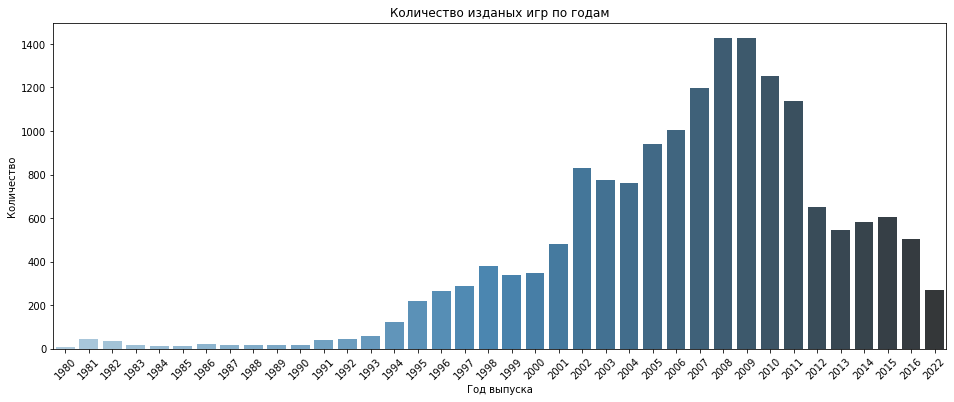

In [41]:
fig, ax = plt.subplots(figsize=(16,6))     
plt.xticks(rotation = 45)
sns.barplot(x=data_name_count['year_of_release'], y=data_name_count['name'], palette="Blues_d");
ax.set_title('Количество изданых игр по годам');
plt.xlabel('Год выпуска');
plt.ylabel('Количество');

Как мы видим по графику до 95 года выпускалось меньше 200 игр в год, далее график идет на увелечение. Рассвет игровой индустрии начался в 2002 году, лучшие показатели в 2008 и 2009 году. 

Далее количество игр пошло на убыль, вероятнее всего это связано с увелечением сложности выпуска компьютерных игр. На производство качественного продукта уходит больше времени и ресурсов. 

Так же у нас могут быть не полные данные по всем годам.

###  Анализ изменения продаж по платформам ###

In [42]:
top_10_platform = data.groupby('platform',
                               as_index=False)['total_sales'].sum().sort_values(
                               by='total_sales',ascending =False).head(10)

In [43]:
top_10_list = top_10_platform['platform'].to_list()

In [44]:
data_year_sales = data.pivot_table(index='year_of_release',
                                   columns='platform', 
                                   values='total_sales', 
                                   aggfunc='sum',
                                   fill_value=0
                          )
data_year_sales.head()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980,11.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,35.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982,28.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1983,5.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
top_10_platform

,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


Получили топ 10 платформ по количеству продаж, посмотрим как распределятся продажи по годам

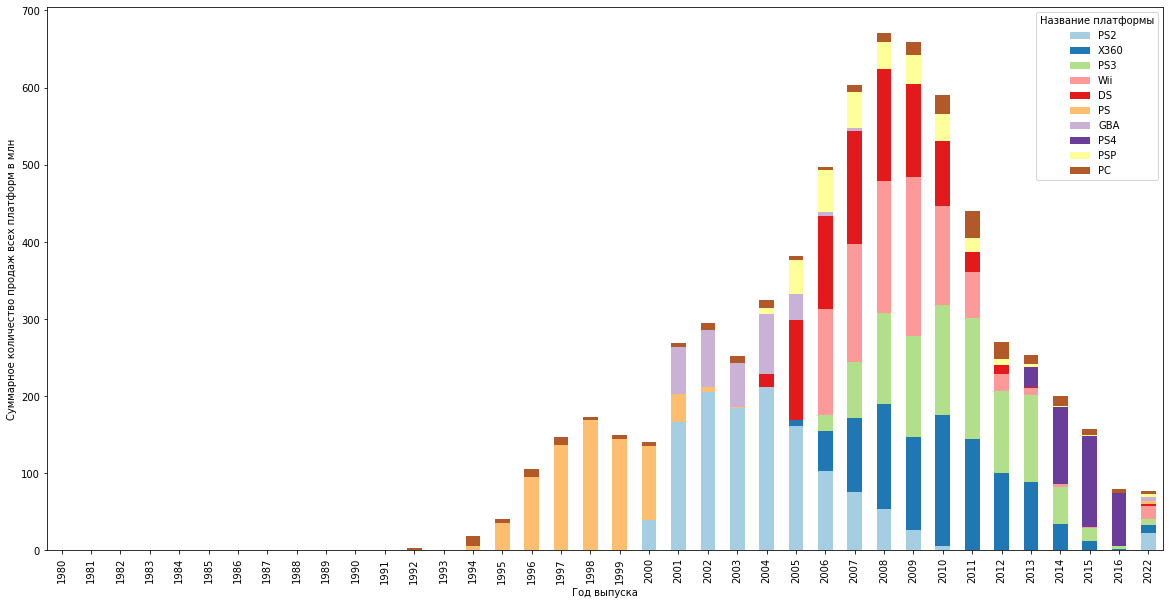

In [46]:
data_year_sales[top_10_list].plot(kind='bar', figsize=(20,10), stacked=True, colormap='Paired');
plt.legend(title='Название платформы')
plt.xlabel('Год выпуска');
plt.ylabel('Суммарное количество продаж всех платформ в млн');

На графике мы видим доли разных платформ от суммарных продаж по годам. Можно увидеть, как в разное время появляются новые платформы, как увеличивается их популярность и как они уходят с рынка, чтобы освободить дорогу новым технологиям. 

В среднем на это требуется 10 лет, с таким периодом на рынок поступает новая продукция. По этой причине в дальнейшем исследовании нам не интересны данные по платформам, которые вышли достаточно давно и уже не актуальны в ныняшнее время. 

Но есть кое-что вечное - ПК. Компьютер не теряет своей актуальности с самого начала своей истории, хотя таких пользователей совсем немного.

Для дальнейшего анализа возьмем интервал 3 года с 2014 по 2016 год, как раз когда на рынок вышла новая консоль PS4. Напомню, что значением 2022 мы заполняли пустые строки, поэтому данный период мы так же исключим

In [47]:
data_good = data.query('2013 < year_of_release < 2022')

In [48]:
data_good['name'].count()

1689

у нас вышло 1689 строк в таблице за период с 2014 по 2016 год

### Анализ лидирования платформ по продажам. Рост и падение.##

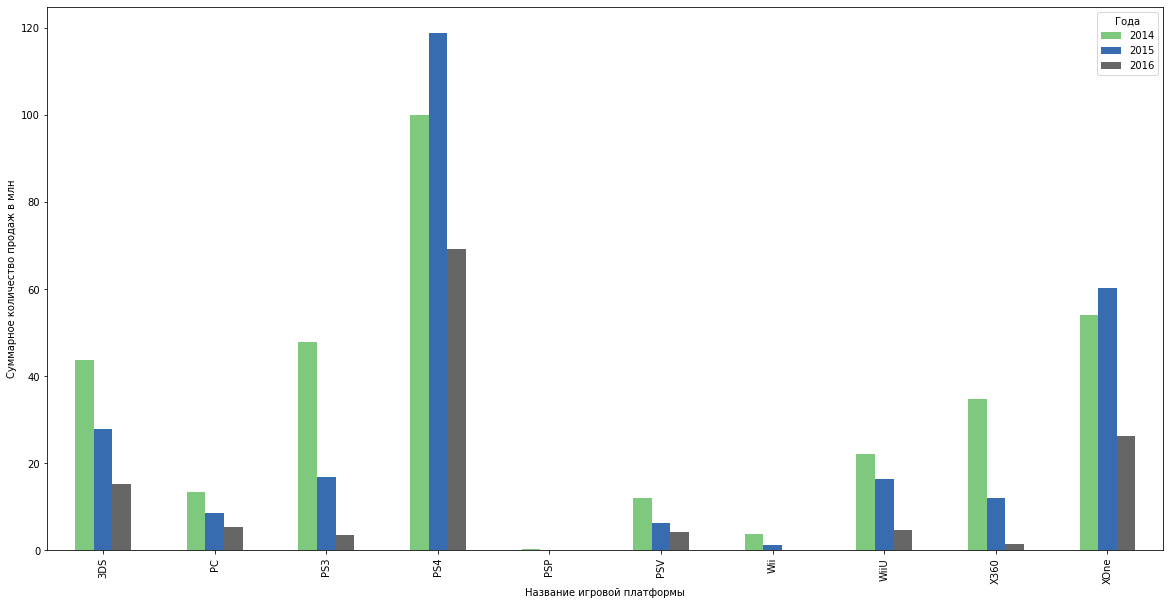

In [49]:
data_good.pivot_table(index='platform',
                      columns='year_of_release', 
                      values='total_sales', 
                      aggfunc='sum',
                      fill_value=0
                     ).plot(kind='bar', figsize=(20,10), colormap='Accent');
plt.legend(title='Года')
plt.xlabel('Название игровой платформы');
plt.ylabel('Суммарное количество продаж в млн');

На графике мы можем видеть количество продаж разных платформ в период с 2014г по 2016г
Самая популрная платформа PS4 - с первого же года она показывает хорошие продажи и на следующий год увеличивает их. Что же на счет 2016 год, тут все платформы показывают спад спроса. Я считаю это связано с возможным отсутсвием данных за 16 год
вторая по популярности платформа Xbox One - она так же показывает неплохие результаты на старте и уверенный рост. Но сильно отстает от PS4 почти в 2 раза

На 3 месте у нас расположилась 3DC - показывает немного другой результат, в 2014г продажи в районе 40 млн и каждый последующий год спад спроса.

Возьмем эти 3 платформы и посмотрим размах продаж, так же добавим инфу по PC, т.к. эта платформа актуальная каждый год с момента выпуска

In [50]:
data_good_platform = data_good.query('platform in ["PS4", "XOne", "3DS", "PC"]')

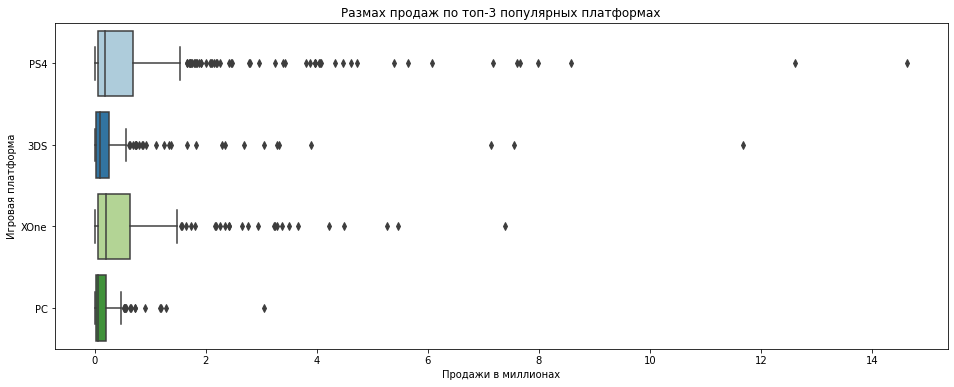

In [51]:
fig, ax = plt.subplots(figsize=(16,6)) 
sns.boxplot(x='total_sales',y='platform',data=data_good_platform, palette='Paired')
ax.set_title('Размах продаж по популярным платформам');
plt.xlabel('Продажи в миллионах');
plt.ylabel('Игровая платформа');

Основная часть продаж игр на всех 4 платформах расположились до 2млн копий. Есть конечно и еденичные экземпляры в 12 и 14 миллионов продаж, посмотрим на основную часть продаж поближе 

(-0.1, 2.0)

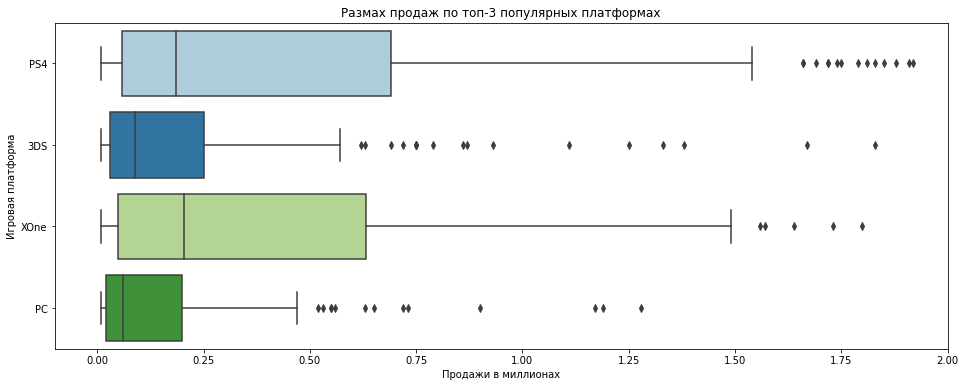

In [52]:
fig, ax = plt.subplots(figsize=(16,6)) 
sns.boxplot(x='total_sales',y='platform',data=data_good_platform, palette='Paired')
ax.set_title('Размах продаж по популярным платформам');
plt.xlabel('Продажи в миллионах');
plt.ylabel('Игровая платформа');
ax.set_xlim([-0.1, 2]) 

PS4 и XboOne показывают похожие графики. Основная часть продаж расположилась в пределах 1,5млн продаж

А 3DS показывает хуже результат - 0,55млн 

PC продажи до 0,25 млн

In [53]:
data_good_platform_score = data_good_platform.query('critic_score > 0 and user_score > 0')

### Продажи PS4 ###

In [54]:
data_platform_ps4 = data_good_platform_score[data_good_platform_score['platform'] == 'PS4']

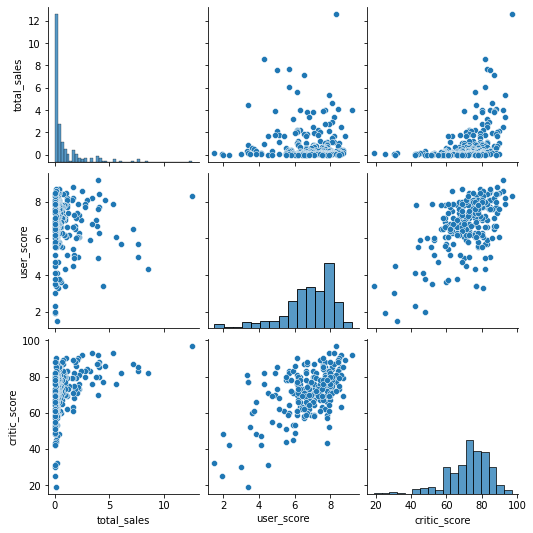

In [55]:
sns.pairplot(data_platform_ps4[['total_sales' ,'user_score', 'critic_score']]);

По графику мы видим, что зависимости продаж от оценки пользователей особо не наблюдается, но люди склонны доверять мнению профессионалов. Подтверждению чему мы можем видеть на графике, есть небольшая зависимость количества покупок от оценки критиков.

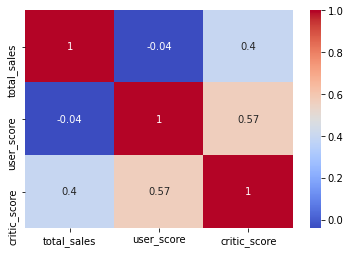

In [56]:
sns.heatmap(data_platform_ps4[['total_sales' ,'user_score', 'critic_score']].corr(), annot=True, cmap='coolwarm');

Корреляция показывает такие же данные, что график выше - почти нулевую корреляцию между продажами и оценкой пользователей
И 0,4 корреляцию между продажами и рейтингом критиков

### Продажи XBONE ###

In [57]:
data_platform_xone = data_good_platform_score[data_good_platform_score['platform'] == "XOne"]

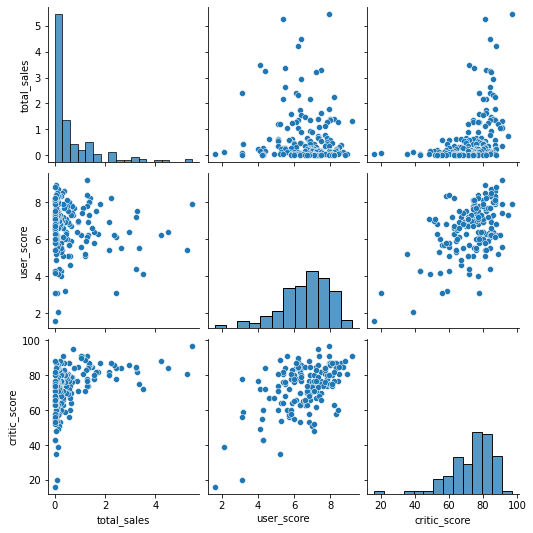

In [58]:
sns.pairplot(data_platform_xone[['total_sales' ,'user_score', 'critic_score']]);

Аналогичная ситуация с платформой Xbox, люди смотрят на рейтинг критиков, но не слепо ему доверяют. 

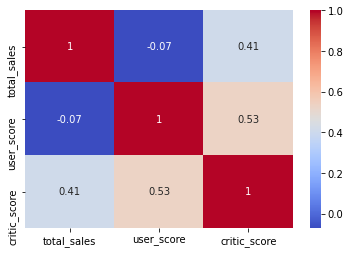

In [59]:
sns.heatmap(data_platform_xone[['total_sales' ,'user_score', 'critic_score']].corr(), annot=True, cmap='coolwarm');

Корреляция между продажами и рейтингом пользователй -0.07

Корреляция между продажами и рейтингом критиков 0.41

### Продажи 3DS ###

In [60]:
data_platform_3ds = data_good_platform_score[data_good_platform_score['platform'] == "3DS"]

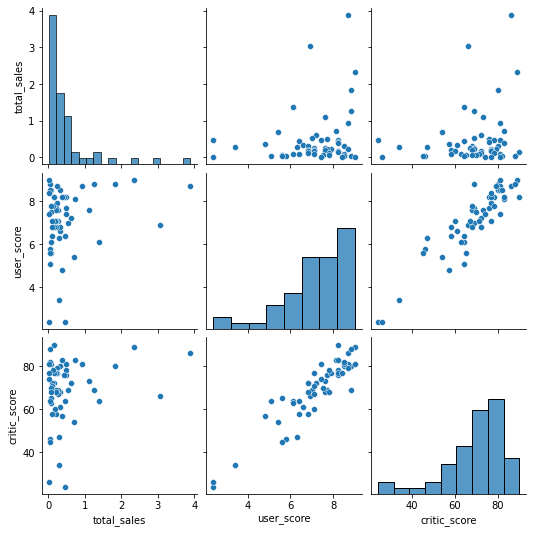

In [61]:
sns.pairplot(data_platform_3ds[['total_sales' ,'user_score', 'critic_score']]);

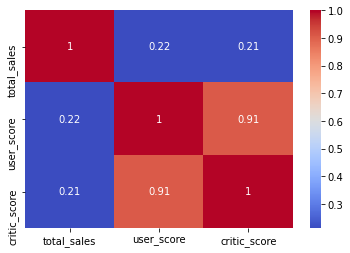

In [62]:
sns.heatmap(data_platform_3ds[['total_sales' ,'user_score', 'critic_score']].corr(), annot=True, cmap='coolwarm');

Пользователи 3DS одинаково осособо не доверяют что оценкам пользователей, что оценкам критиков

### Общее распределение игр по жанрам ###

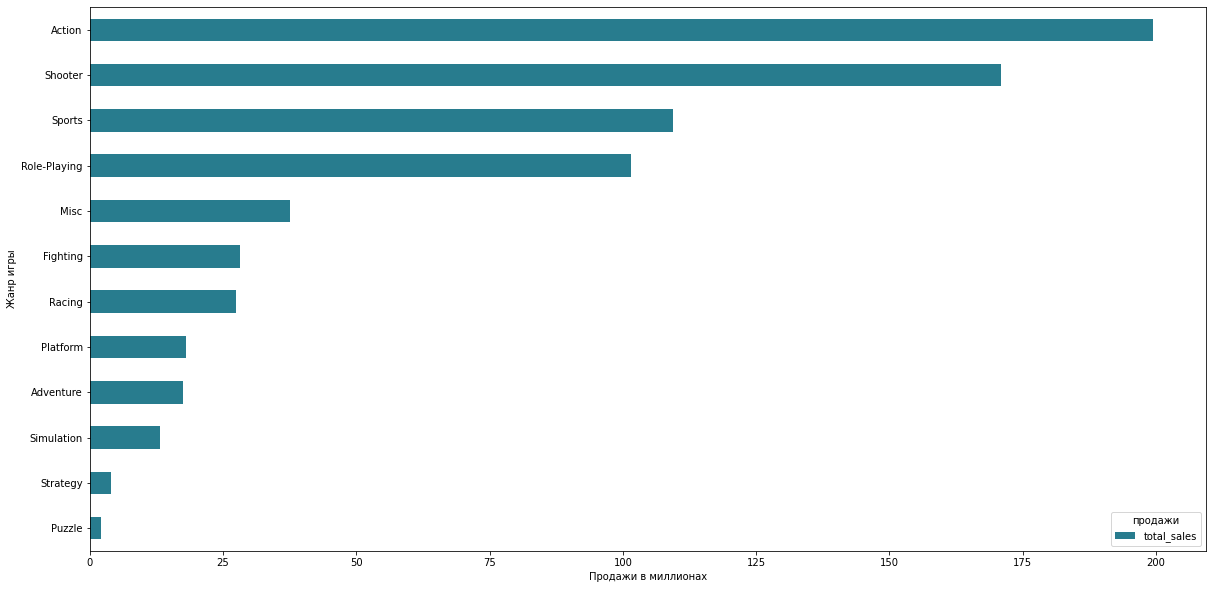

In [63]:
data_good.groupby('genre',as_index=False)['total_sales'].sum().sort_values(
                                            by='total_sales').plot(
                                            kind='barh', 
                                            x='genre', 
                                            figsize=(20,10), 
                                            color="#287C8EFF",
                                            );
plt.legend(title='продажи')
ax.set_title('Прибыльность игр по жанрам');
plt.xlabel('Продажи в миллионах');
plt.ylabel('Жанр игры');

По графику мы видим топ самых продаваемых жанров в игровой индустрии - Экшен, Шутеры, Спорт, Ролевые Игры и Аркада

Самые непопулярные - Стратегии и Пазлы


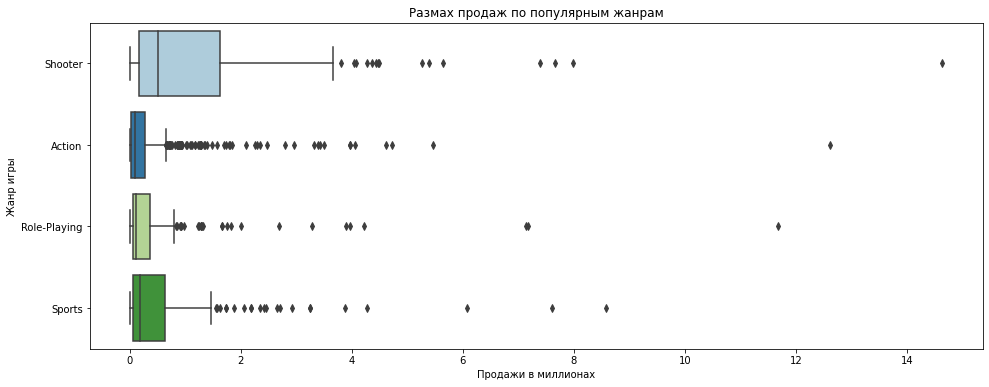

In [89]:
data_good_genre = data_good.query('genre in ["Action", "Shooter", "Sports", "Role-Playing"]')
fig, ax = plt.subplots(figsize=(16,6)) 
sns.boxplot(x='total_sales',y='genre',data=data_good_genre, palette='Paired')
ax.set_title('Размах продаж по популярным жанрам');
plt.xlabel('Продажи в миллионах');
plt.ylabel('Жанр игры');

(-0.1, 4.0)

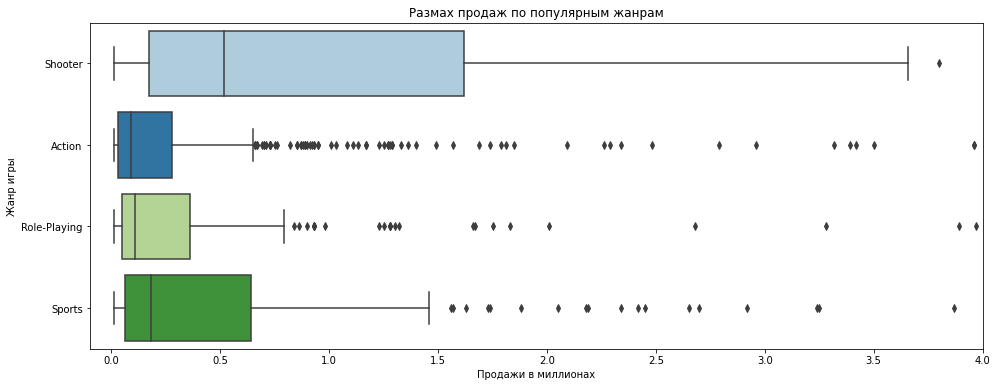

In [91]:
fig, ax = plt.subplots(figsize=(16,6)) 
sns.boxplot(x='total_sales',y='genre',data=data_good_genre, palette='Paired')
ax.set_title('Размах продаж по популярным жанрам');
plt.xlabel('Продажи в миллионах');
plt.ylabel('Жанр игры');
ax.set_xlim([-0.1, 4]) 

Что мы видим по графику: самый продаваемый жанр Экшен показывает в среднем сильно хуже результаты, чем жанр Шутер и Спорт. Вылез он на первое место только за счет еденичных успещных проектов. 

Вывод, данные по суммарным продажам могут быть не правдободобны из-за еденичных хороших тайтлов, рассмотрим средние продажи по жанрам. Данный график должен быть более информативен в перспективе качественных продаж

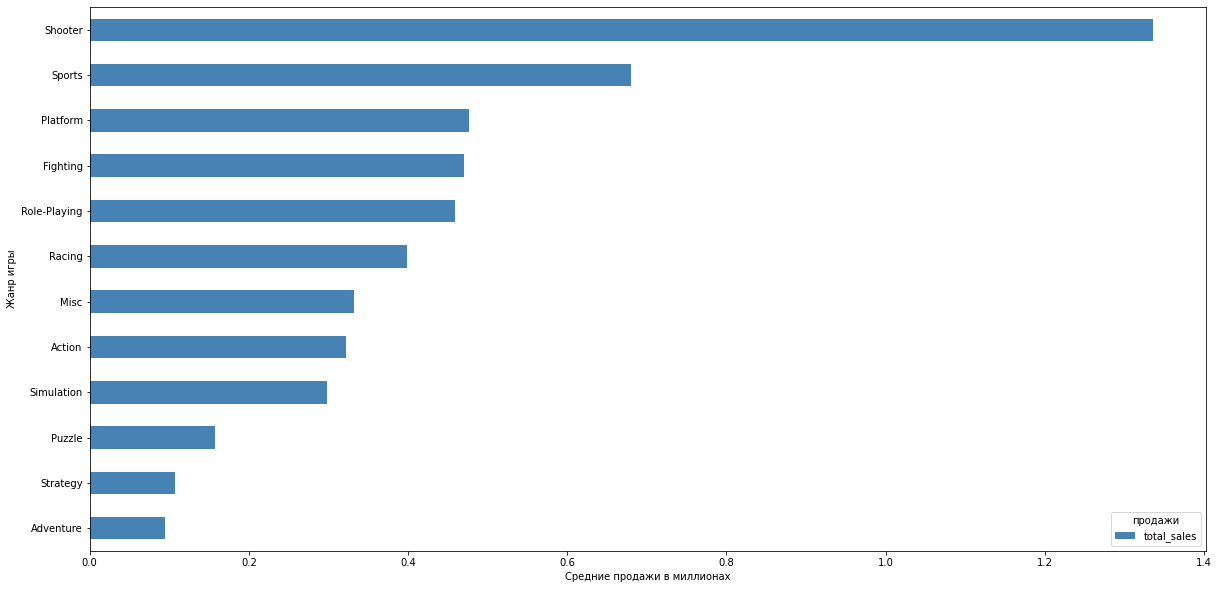

In [83]:
data_good.groupby('genre',as_index=False)['total_sales'].mean().sort_values(
                                            by='total_sales').plot(
                                            kind='barh', 
                                            x='genre', 
                                            figsize=(20,10), 
                                            color="steelblue",
                                            );
plt.legend(title='продажи')
plt.xlabel('Средние продажи в миллионах');
plt.ylabel('Жанр игры');
ax.set_title('Средняя прибыльность игр по жанрам');

Данный же график показывает совсем другую картину. Топ 3 жанров - Шутеры, Спорт и Платформеры
Экшен, который до этого был на 1 месте, в средних показателях улетел аж на 8 место

Самые в среднем плохо продающиеся Стратегии и Приключения

## Составление портрета пользователя каждого региона ##

### Анализ продаж в разных регионах в зависимости от игровой платформы ###

In [64]:
top_5_na_sales = data_good.groupby('platform', 
                                        as_index=False)['na_sales'].sum().sort_values(
                                                                          by='na_sales', 
                                                                          ascending =False).head().reset_index(
                                                                                                   drop=True)
top_5_eu_sales = data_good.groupby('platform', 
                                        as_index=False)['eu_sales'].sum().sort_values(
                                                                          by='eu_sales', 
                                                                          ascending =False).head().reset_index(
                                                                                                    drop=True)                                                                                         
top_5_jp_sales = data_good.groupby('platform', 
                                        as_index=False)['jp_sales'].sum().sort_values(
                                                                          by='jp_sales', 
                                                                          ascending =False).head().reset_index(
                                                                                                    drop=True)

In [65]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [66]:
display_side_by_side(top_5_na_sales,
                     top_5_eu_sales,
                     top_5_jp_sales, 
                     titles=['Топ-5 в Сев.Америке','Топ-5 в Европе', 'Топ-5 в Японии'])

,platform,na_sales
0,PS4,98.61
1,XOne,81.27
2,X360,28.30
3,3DS,22.64
4,PS3,22.05
,platform,eu_sales
0,PS4,130.04
1,XOne,46.25
2,PS3,25.54
3,PC,17.97


Можем видить, что топ-5 популярных платформ в Северной Америке и Европе не сильно отличается. Первые 2 места уверено занимают PS4 и XOne, далее рейтинг различается

В Японии же совсем другая картина - 3DC на первом месте, но PS4 так же входит в топ-3

В топе по Японии мы видим появление новых лиц - PSV и WIIU 

Не удивительно, что в топе по Японии лидирует Sony и Nintendo - это Японские компании. В Японии не очень пользуются зарубежной продукцией, если есть Японские аналоги. 

### Анализ продаж в разных регионах в зависимости от жанра игры ###

In [67]:
top_5_na_sales_genre = data_good.groupby('genre', 
                                        as_index=False)['na_sales'].sum().sort_values(
                                                                          by='na_sales', 
                                                                          ascending =False).head().reset_index(
                                                                                                   drop=True)
top_5_eu_sales_genre = data_good.groupby('genre', 
                                        as_index=False)['eu_sales'].sum().sort_values(
                                                                          by='eu_sales', 
                                                                          ascending =False).head().reset_index(
                                                                                                    drop=True)                                                                                         
top_5_jp_sales_genre = data_good.groupby('genre', 
                                        as_index=False)['jp_sales'].sum().sort_values(
                                                                          by='jp_sales', 
                                                                          ascending =False).head().reset_index(
                                                                                                    drop=True)

In [68]:
display_side_by_side(top_5_na_sales_genre,
                     top_5_eu_sales_genre,
                     top_5_jp_sales_genre, 
                     titles=['Топ-5 в Сев.Америке','Топ-5 в Европе', 'Топ-5 в Японии'])

,genre,na_sales
0,Shooter,79.02
1,Action,72.53
2,Sports,46.13
3,Role-Playing,33.47
4,Misc,15.05
,genre,eu_sales
0,Action,74.68
1,Shooter,65.52
2,Sports,45.73
3,Role-Playing,28.17


По данным выше мы видим, что опять же предпочтения Северной Америки и Европы достаточно схожи. Что в одной, что в другой таблице мы видим одни и те же жанры, но какие то на разных местах. 

Что по предпочтениям в Японии - тут абсолютно другая картина. В Японии очень любят играть в Ролевые Игры - этот жанр вышел на первое место. 

Далее у нас расположился жанр Экшен - так же популярен и в других регионах и на 3 месте Файтинги

### Влияние рейтинга ESRB на продажи в отдельном регионе ###

* EC - для всех(для детей) 0+
* E - для всех 6+
* E10+ - для всех 10+ 
* K-A - так же для всех(старая формулировка)
* T -  для подростков 16+
* M - для взрослых 18+
* AO - только для взрослых 18+ ( сцены откровееного сексуального содержания)
* RP - рейтинг уточняется

In [69]:
top_5_na_sales_ESRB = data_good.groupby('rating', 
                                        as_index=False)['na_sales'].sum().sort_values(
                                                                          by='na_sales', 
                                                                          ascending =False).reset_index(
                                                                                                   drop=True)
top_5_eu_sales_ESRB = data_good.groupby('rating', 
                                        as_index=False)['eu_sales'].sum().sort_values(
                                                                          by='eu_sales', 
                                                                          ascending =False).reset_index(
                                                                                                drop=True)                                                                                         
top_5_jp_sales_ESRB = data_good.groupby('rating', 
                                        as_index=False)['jp_sales'].sum().sort_values(
                                                                          by='jp_sales', 
                                                                          ascending =False).reset_index(
                                                                                                drop=True)

In [70]:
display_side_by_side(top_5_na_sales_ESRB,
                     top_5_eu_sales_ESRB,
                     top_5_jp_sales_ESRB, 
                     titles=['Продажи в Сев.Америке','Продажи в Европе', 'Продажи в Японии'])

,rating,na_sales
0,M,115.23
1,T,73.41
2,E,62.19
3,E10+,33.23
,rating,eu_sales
0,M,109.53
1,E,74.44
2,T,60.55
3,E10+,26.16
,rating,jp_sales


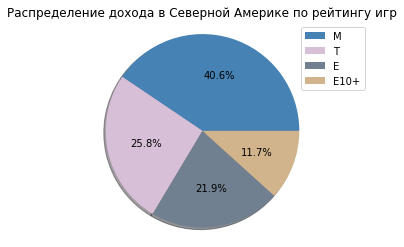

In [71]:
labels = ["M", "T", "E", "E10+"]
color = ["steelblue","thistle","slategrey","tan"]
fig, ax = plt.subplots()
ax.pie(top_5_na_sales_ESRB['na_sales'], autopct='%1.1f%%', shadow=True, colors=color)
ax.axis("equal")
ax.legend(labels, loc='upper right')
ax.set_title('Распределение дохода в Северной Америке по рейтингу игр')
plt.show()

В Северной Америке самый хорошо продающийся рейтинг - M - для взрослых 18+
Далее идут игры для подростков и детей

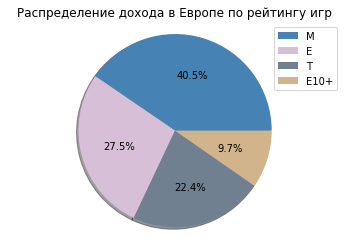

In [72]:
labels = ["M", "E", "T", "E10+"]
color = ["steelblue","thistle","slategrey","tan"]
fig, ax = plt.subplots()
ax.pie(top_5_eu_sales_ESRB['eu_sales'], autopct='%1.1f%%', shadow=True, colors=color)
ax.axis("equal")
ax.legend(labels, loc='upper right')
ax.set_title('Распределение дохода в Европе по рейтингу игр')
plt.show()

В Европе так же самый хорошо продающийся рейтинг - M - для взрослых 18+
Далее идут игры для детей и подростков

Взрослые люди тратят на игры для себя больше денег, чем на игры детей

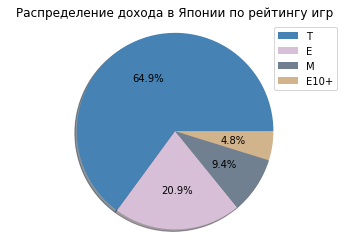

In [73]:
labels = ["T", "E", "M", "E10+"]
color = ["steelblue","thistle","slategrey","tan"]
fig, ax = plt.subplots()
ax.pie(top_5_jp_sales_ESRB['jp_sales'], autopct='%1.1f%%', shadow=True, colors=color)
ax.axis("equal")
ax.legend(labels, loc='upper right')
ax.set_title('Распределение дохода в Японии по рейтингу игр')
plt.show()

В Японии же так же абсолютно другая картина. Игры с рейтингом М только на 3 месте
На первых двух местах игры для подростков и детей, всегда держим в голове симулятор свиданий

## Проверка гипотез ##

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые ###

Формируем гипотезу: Средний рейтинг пользователей по платформам Xbox One и PC равна. 

Альтернативная гипотеза: Средний рейтинг пользователей по платформам Xbox One и PC - не равна

In [74]:
data_good_pc = data_good.query('platform == "PC" and user_score > 0')
data_good_xbone = data_good.query('platform == "XOne" and user_score > 0')

In [92]:
print('Количество оценок по платформе PC', len(data_good_pc))
print('Количество оценок по платформе Xbox One', len(data_good_xbone))

alpha = .05
results = st.ttest_ind(
    data_good_pc['user_score'], 
    data_good_xbone['user_score'],)

print('p-значение:', '{:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Количество оценок по платформе PC 123
Количество оценок по платформе Xbox One 166
p-значение: 0.10759
Не получилось отвергнуть нулевую гипотезу


Для проверки гипотезы был выбран t-тест Стьюдента, т.к. мы имеем две независимые друг от друга генеральные совокупности. 

Как мы видим из получившегося результата, не получилось отвергнуть нулевую гипотезу. 

### Средние пользовательские рейтинги жанров Action и Sports разные. ###

In [76]:
data_action = data_good.query('genre == "Action" and user_score > 0')
data_sports = data_good.query('genre == "Sports" and user_score > 0')

Формируем гипотезу: Средний рейтинг пользователей по жанру Action и Sports - равны

Альтернативная гипотеза: Средний рейтинг пользователей по жанру Action и Sports - не равны

In [77]:
print('Количество оценок по жанра Аction', len(data_action))
print('Количество оценок по жанра Sports', len(data_sports))

alpha = .05
results = st.ttest_ind(
    data_action['user_score'], 
    data_sports['user_score'],
    equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Количество оценок по жанра Аction 298
Количество оценок по жанра Sports 127
p-значение: 1.1498582234651753e-14
Отвергаем нулевую гипотезу


Для проверки гипотезы был выбран t-тест Стьюдента, т.к. мы имеем две независимые друг от друга генеральные совокупности. Но т.к. выборки у нас разного размера, то решено было добавить параметр equal_var = False

Как мы видим из получившегося результата, нулевая гипотеза отвергнута 

## Шаг 5. Вывод

Цель: найти потенциально популярный продукт в игровой индустрии для интернет-магазина «Стримчик»

Для анализа нам были предоставлены данные по играм на разных платформах до 2016 года.(Данные за 2016 год могут быть неполными.)

* Названия столбцов были приведены к типу snake_case
* Пропуски в столбцах 
1.  Name - были удалены
2.  Year_of_Release - заполнены значением 2022 и не использованы в исследовании
3.  Genre -  удалены
4.  Critic_Score - небольшая часть заполнена значениями на основании столбца User_Score.
    Остальные заполнены значением -10
5.  User_Score -  небольшая часть заполнена значениями на основании столбца Critic_Score.
    Остальные заполнены значением -1
6.  Rating - заполнены самым часто встречающемся значением по жанру                   
* Year_of_Release - приведем к формату даты и 
* User_Score - к числу с плавающей точкой
* Critic_Score - к целому числу

До 1995 года выпускалось меньше 200 игр в год. Рассвет игровой индустрии начался в 2002 году, лучшие показатели в 2008 и 2009 году. 

Далее количество игр пошло на убыль, вероятнее всего это связано с увелечением сложности выпуска компьютерных игр. На производство качественного продукта уходит больше времени и ресурсов. 

В среднем на срок жизни консоли занимает 10 лет. По этой причине в дальнейшем исследовании нам были не интересны данные по платформам, которые вышли достаточно давно и уже не актуальны в ныняшнее время. 

Для дальнейшего анализа возьмем интервал 3 года с 2014 по 2016 год. В это время вышли самые новые консоли.


Самыми хорошо продаваемыми консолями в мире оказались 
1. PS4
2. Xbox One
3. 3DS

*Были проверены следующие гипотезы*

Средние пользовательские рейтинги платформ Xbox One и PC одинаковы
* не получилось отвергнуть нулевую гипотезу.

Средний рейтинг пользователей по жанру Action и Sports - равны
* отвергли нулевую гипотезу

Было выявлено, что типичный портрет потребителя отличается в зависимости от региона. По этой причине:

НЕОБХОДИМО ДЕЛАТЬ РАЗНЫЕ РЕКЛАМНЫЕ КАМПАНИИ НА РАЗНЫЕ РЕГИОНЫ

Потребитель в Севреной Америке и Европе не сильно отливается, поэтому можем рассмтравить эти 2 региона вместе.

In [93]:
display_side_by_side(top_5_eu_sales,
                     top_5_eu_sales_genre, 
                     titles=['Топ-5 продаж в Европе','Топ-5 жанров в Европе'])

,platform,eu_sales
0,PS4,130.04
1,XOne,46.25
2,PS3,25.54
3,PC,17.97
4,3DS,16.12
,genre,eu_sales
0,Action,74.68
1,Shooter,65.52
2,Sports,45.73
3,Role-Playing,28.17


In [94]:
display_side_by_side(
                     top_5_jp_sales,
                     top_5_jp_sales_genre,
                     titles=['Топ-5 продаж в Японии','Топ-5 жанров в Японии'])

,platform,jp_sales
0,3DS,44.24
1,PS4,15.02
2,PSV,14.54
3,PS3,11.22
4,WiiU,7.31
,genre,jp_sales
0,Role-Playing,31.16
1,Action,29.58
2,Fighting,6.37
3,Misc,5.61


Итого: Приставки и жанры игр у которых самый хорошие показатели 
Европа и Северная Америка 
* Топ-3 популярных приставок: PS4, XBox One и PS3
Так же не стоит забывать про PC - данное устройство показывает хоть и небольшую, но стабильную популярность у определнной части пользователей на протяжении 20 лет
* Топ-3 популырных жанра Экшен, Шутеры и Спорт

Япония
* Топ-3 популярные приставки: 3DC, PS4, PSV
* Топ-3 популырных жанра Role-Playing, Экшен и Файтинги
Так же в Японии очень популярны портативные приставки, но Япония занимает небольшую долю от всего игрового рынка.

Так же игроки чаще обращают внимание и лучше покупают игры, у которых хороший рейтинг критиков. Для лучшего продвижения игр стоит учитывать этот факт и договориваться об обзорах с игровыми критиками для рекламной кампании
